In [1]:
! nvidia-smi

Wed Mar 17 11:02:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Reference : https://github.com/pytorch/examples/tree/6c8e2bab4d45f2386929c83bb4480c18d2b660fd/fast_neural_style**
## Fast style transfer based on TransformerNet

In [74]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import torch
from PIL import Image
import re
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Resize

## saved_models zip file referred in above git hub link is available in https://www.dropbox.com/s/lrvwfehqdcxoza8/saved_models.zip?dl=0 

In [71]:
gdd.download_file_from_google_drive(file_id='1uLkrrQTluZc4sS6ELeKXpwTz52rykUxS',dest_path='/content/saved_models.zip',unzip=False)

Extracting all the model files that are present in zip file. There are 4 files - candy.pth, mosaic.pth, rain_princess.pth & udnie.pth

In [72]:
from zipfile import ZipFile
with ZipFile('/content/saved_models.zip', mode='r') as input:
  input.extractall('.')

In [75]:
content_transform = T.Compose([
    Resize(400),                           
    T.ToTensor(),
    T.Lambda(lambda x: x.mul(255))
])

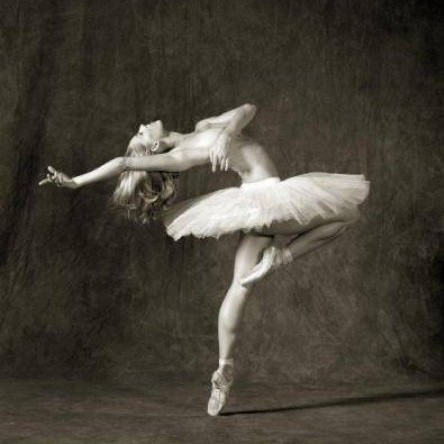

In [87]:
content_image = Image.open('/content/dancing.jpg')
content_image

In [88]:
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0) # To add fake dimension for model to process

### Model corresponding to fast style transfer. Each of the pth pre-trained weights can be loaded against this model & model will give style transferred images

In [29]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=float(self.upsample))
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

## Testing mosaic.pth

### Transformernet saved model that we are using has some deprecated keys when latest pytorch versions were released. So trying to load these models as such will cause failure as shown below. 

In [95]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load('/content/saved_models/mosaic.pth')
    style_model.load_state_dict(state_dict)
    output = style_model(content_image)
output = output.squeeze(0)
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()
Image.fromarray(out.astype("uint8"))  

RuntimeError: ignored

### Hence we need to remove these deprecated keys from model & try to load it. From below we can see that keys matching the pattern 'in1.running_mean', 'in1.running_var' are removed as they are deprecated. Basically keys having running_mean & running_var will cause issues eg: 'feature1.running_mean' will cause issues

In [96]:
state_dict = torch.load('/content/saved_models/candy.pth')
for k in list(state_dict.keys()):
        print('k:',k)
        if re.search(r'in\d+\.running_(mean|var)$', k):
            print('k matching search:',k)
            del state_dict[k]
print('***Rerunning to confirm deprecated keys are removed***') 
for k in list(state_dict.keys()):
        print('k:',k)
        if re.search(r'in\d+\.running_(mean|var)$', k):
            print('k matching search:',k)
            del state_dict[k]

k: conv1.conv2d.weight
k: conv1.conv2d.bias
k: in1.weight
k: in1.bias
k: in1.running_mean
k matching search: in1.running_mean
k: in1.running_var
k matching search: in1.running_var
k: conv2.conv2d.weight
k: conv2.conv2d.bias
k: in2.weight
k: in2.bias
k: in2.running_mean
k matching search: in2.running_mean
k: in2.running_var
k matching search: in2.running_var
k: conv3.conv2d.weight
k: conv3.conv2d.bias
k: in3.weight
k: in3.bias
k: in3.running_mean
k matching search: in3.running_mean
k: in3.running_var
k matching search: in3.running_var
k: res1.conv1.conv2d.weight
k: res1.conv1.conv2d.bias
k: res1.in1.weight
k: res1.in1.bias
k: res1.in1.running_mean
k matching search: res1.in1.running_mean
k: res1.in1.running_var
k matching search: res1.in1.running_var
k: res1.conv2.conv2d.weight
k: res1.conv2.conv2d.bias
k: res1.in2.weight
k: res1.in2.bias
k: res1.in2.running_mean
k matching search: res1.in2.running_mean
k: res1.in2.running_var
k matching search: res1.in2.running_var
k: res2.conv1.conv2d

### Loading mosaic.pth with fix & generating image

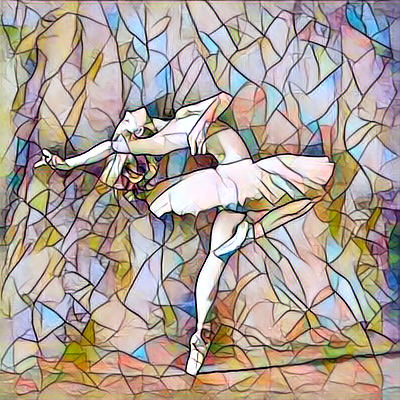

In [97]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load('/content/saved_models/mosaic.pth')
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    output = style_model(content_image)
output = output.squeeze(0)
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()
Image.fromarray(out.astype("uint8"))    

# Testing udnie.pth

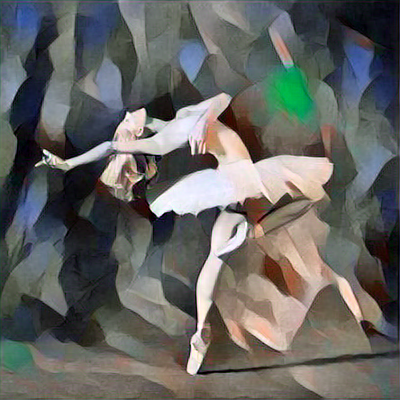

In [98]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load('/content/saved_models/udnie.pth')
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    output = style_model(content_image)
output = output.squeeze(0)
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()
Image.fromarray(out.astype("uint8"))    

# Testing candy.pth

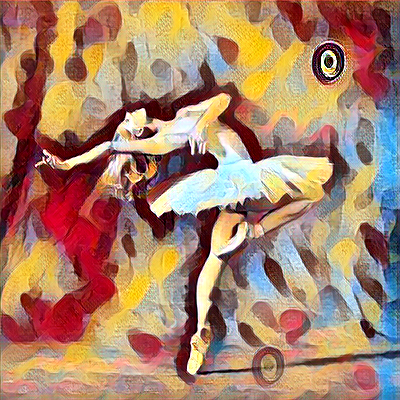

In [99]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load('/content/saved_models/candy.pth')
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    output = style_model(content_image)
output = output.squeeze(0)
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()
Image.fromarray(out.astype("uint8"))  
            

# Testing rain_princess.pth

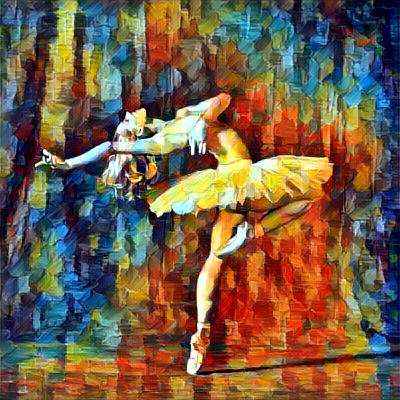

In [100]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load('/content/saved_models/rain_princess.pth')
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    output = style_model(content_image)
output = output.squeeze(0)
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()
Image.fromarray(out.astype("uint8"))

# Saving the **gpu model** using torch.jit.script after removing deprecated keys from pre-trained 'candy.pth', 'mosaic.pth', 'rain_princess.pth', 'udnie.pth'

In [105]:
from pathlib import Path
root = Path('/content/saved_models')
models = ['candy.pth', 'mosaic.pth', 'rain_princess.pth', 'udnie.pth']
out_model = Path('/content/fast_style_transfer_models_fixed_gpu')
out_model.mkdir(parents=True, exist_ok=True)

In [106]:
for model in models:
    m_path = root / model

    style_model = TransformerNet()
    state_dict = torch.load(m_path)
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    scripted_model = torch.jit.script(style_model)
    print(f'=> saving {m_path.stem}')
    scripted_model.save(str(out_model / f'{m_path.stem}_gpu_scripted.pt'))

=> saving candy
=> saving mosaic
=> saving rain_princess
=> saving udnie


### Testing if saved gpu model works

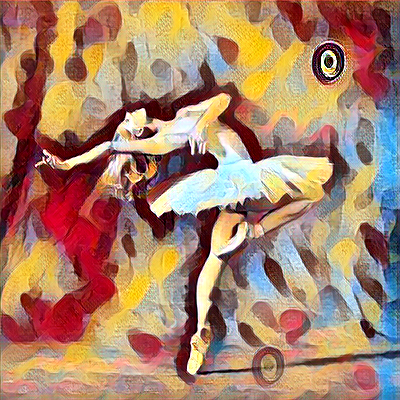

In [114]:
with torch.no_grad():  # We need to use no_grad() else have to detach() the output to display as output with grad cant be dispalyed
    style_model = torch.jit.load('/content/fast_style_transfer_models_fixed_gpu/candy_gpu_scripted.pt')
    output = style_model(content_image)
output = output.squeeze(0)
#out = output.permute(1, 2, 0).cpu().clamp(0, 255).detach().numpy()
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()  
Image.fromarray(out.astype("uint8"))

# Saving the **cpu model** using torch.jit.script after removing deprecated keys from pre-trained 'candy.pth', 'mosaic.pth', 'rain_princess.pth', 'udnie.pth'

In [108]:
from pathlib import Path
root = Path('/content/saved_models')
models = ['candy.pth', 'mosaic.pth', 'rain_princess.pth', 'udnie.pth']
out_model = Path('/content/fast_style_transfer_models_fixed_cpu')
out_model.mkdir(parents=True, exist_ok=True)

In [109]:
for model in models:
    m_path = root / model

    style_model = TransformerNet()
    style_model.to('cpu')   ## Changing to cpu
    state_dict = torch.load(m_path)
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    scripted_model = torch.jit.script(style_model)
    print(f'=> saving {m_path.stem}')
    scripted_model.save(str(out_model / f'{m_path.stem}_cpu_scripted.pt'))

=> saving candy
=> saving mosaic
=> saving rain_princess
=> saving udnie


### Testing if saved cpu model works

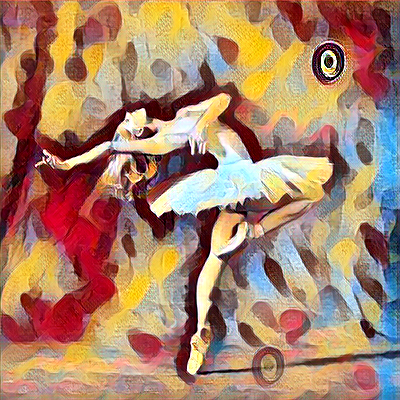

In [112]:
with torch.no_grad():
    style_model = torch.jit.load('/content/fast_style_transfer_models_fixed_cpu/candy_cpu_scripted.pt')
    output = style_model(content_image)
output = output.squeeze(0)
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()  
Image.fromarray(out.astype("uint8"))

# Zip & Copy the fixed CPU and GPU models to gdrive 

In [115]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [120]:
from zipfile import ZipFile
import zipfile
import os

In [121]:
def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

In [122]:
# Checking current directory 
!pwd

/content


In [123]:
# Repointing to gdrive directory where we need to route the zip file
os.chdir('/content/gdrive/My Drive/EVA4P2_S8_Data/Model_Weights_Fast_Style_Transfer')
!pwd

/content/gdrive/My Drive/EVA4P2_S8_Data/Model_Weights_Fast_Style_Transfer


In [124]:
zipfile_name = ' fast_style_transfer_models_cpu'
#Running zip command. This will zip all the files available in 'fast_style_transfer_models_fixed_cpu' & place in current gdrive directory
zipfolder(zipfile_name, '/content/fast_style_transfer_models_fixed_cpu/')

In [126]:
zipfile_name = ' fast_style_transfer_models_gpu'
#Running zip command. This will zip all the files available in 'fast_style_transfer_models_fixed_gpu' & place in current gdrive directory
zipfolder(zipfile_name, '/content/fast_style_transfer_models_fixed_gpu/')